# Fake News Erkennung mit Hilfe von Machine Learning

## Inhaltsverzeichnis

* [1. Verwendete Bibliotheken](#chapter1)
* [2. Vorbereitung der Daten](#chapter2)
    * [2.1 Laden der Daten](#chapter2-1)
    * [2.2 Preprocessing](#chapter2-2)
* [3. Datenexploration](#chapter3)
    * [3.1 Klassen-Verteilung](#chapter3-1)
    * [3.2 Word Clouds](#chapter3-2)
    * [3.3 Top 10 verwendeten Wörter](#chapter3-3)
    * [3.4 Artikel Längen](#chapter3-4)
* [4. Modelle](#chapter4)
    * [4.1 Naive Bayes Klassifizierer](#chapter4-1)
    * [4.2 Gradient Boosting Klassifizierer](#chapter4-2)
    * [4.3 Support Vector Maschinen](#chapter4-3)
* [5. Praktische Anwendung](#chapter5)

## Verwendete Bibliotheken <a class="anchor" id="chapter1"></a>

In [17]:
# Dataframes
import pandas as pd

# Artical Retrival
import requests
import newspaper
import re

# Text Preprocessing
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Model Preparation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Feature Extraction
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Exploration and Plotting  
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import cufflinks as cf
from wordcloud import WordCloud 
import numpy as np
import seaborn as sns
from collections import Counter 

# Machine Learning Models and Evaluation
from sklearn import naive_bayes, svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, plot_confusion_matrix

# Deep Learning
import tensorflow as tf

## Vorbereitung der Daten <a class="anchor" id="chapter2"></a>

Der erste Schritt beim Erstellen eines Machine Learning Modells sollte immer die Vorbereitung, also das Preprocessing bzw. Bereinigen, der Daten sein. Die Genauigkeit der Modelle hängt stark von der Qualität der Daten ab, daher lohnt es sich Zeit in die Aufbereitung zu stecken. Bei der Vorbereitung von Texten sollte folgende Schritte durchgeführt werden:
* Transformation zu Kleinbuchstaben
* Tokenisierung (Auftrennen der Texte in Wort-Liste)
* Entfernen von Satzzeichen
* Entfernen von Stopwörtern (Häufig verwendete Wörter z.B. Artikel, Konjunktoren)
* Lemmatisierung oder Stemming
* Optional: Entfernen von Zahlen, einzelnen Buchstaben

Im folgenden wird der [Trainingsdatensatz](https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/corona_fake.csv) von Susan Li, welche mit Hilfe von Projekten wie Lead Stories, Poynter, FactCheck.org etc. 1100 Artikel und Social Media Post gesammelt und kategorisiert hat.

### Laden der Daten <a class="anchor" id="chapter2-1"></a>

In [2]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
# Articles
# Read Dataset
dataset_train = pd.read_csv('Constraint_English_Train - Sheet1.csv')
dataset_test = pd.read_csv('english_test_with_labels - Sheet1.csv')

# Remove empty rows
dataset_train = dataset_train[dataset_train['tweet'].notna()]
dataset_train = dataset_train[dataset_train['label'].notna()]
dataset_test = dataset_test[dataset_test['tweet'].notna()]
dataset_test = dataset_test[dataset_test['label'].notna()]

# Unifrom labels
dataset_train['label'] = dataset_train['label'].str.lower()
dataset_test['label'] = dataset_test['label'].str.lower()

dataset_train[:4]

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real


### Preprocessing <a class="anchor" id="chapter2-2"></a>

In [5]:
le = preprocessing.LabelEncoder()

def clean_data(dataset):
    
    # Articles
    texts_clean = []

    for index, row in dataset.iterrows():

        # article text
        content = row['tweet']

        if type(content) != str:
            continue

        # content to lower and split into words 
        tokenizer = RegexpTokenizer(r'\w+')
        content = tokenizer.tokenize(content.lower())

        # content without punctuation
        punctuation_chars = string.punctuation + '”' + '“' + '—'
        translation_func = str.maketrans('', '', punctuation_chars)
        content = [w.translate(translation_func) for w in content]

        # content without stopwords
        stop_words = set(stopwords.words('english'))
        content = [w for w in content if not w in stop_words]

        # content without numbers
        content = [w for w in content if not w.isdigit()]

        # content without single letters
        content = [w for w in content if not len(w) == 1]

        # content lemmatized
        lemmatizer = WordNetLemmatizer()
        content = [lemmatizer.lemmatize(w) for w in content]

        # add cleaned data to dataset
        texts_clean.append(" ".join(content))

    # Add cleaned text and text length to the dataframe
    dataset['text_clean'] = texts_clean
    dataset['text_length'] = [len(t.split()) for t in dataset['tweet']]

    # Encode class labels
    labels_encoded=le.fit_transform(dataset['label'])
    dataset['label_encoded'] = labels_encoded
    
    return dataset

# Preprocess data
dataset_train = clean_data(dataset_train)
dataset_test = clean_data(dataset_test)

# Whole dataset
dataset = dataset_train.append(dataset_test)

labels_encoded=le.fit_transform(dataset['label'])
dataset['label_encoded'] = labels_encoded

# Get Training/Test data
train_text = dataset_train['text_clean']
test_text = dataset_test['text_clean']
train_label = dataset_train['label_encoded']
test_label = dataset_test['label_encoded']

# Vectorize Data
tfidf_vect = TfidfVectorizer(max_features=10000)
tfidf_vect.fit(dataset['text_clean'])
train_text_tfidf = tfidf_vect.transform(train_text)
test_text_tfidf = tfidf_vect.transform(test_text)

dataset[:4]

,id,tweet,label,text_clean,text_length,label_encoded
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently report death general discrepancy...,29,1
1,2,States reported 1121 deaths a small rise from ...,real,state reported death small rise last tuesday s...,18,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost us pandemic e...,16,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona covid testing laboratory ind...,27,1


## Datenexploration <a class="anchor" id="chapter3"></a>

Der nächste Schritt, um ein gutes Modell zu erstellen, ist die Analyse der Datenquelle. Die Auseinandersetzung mit den Trainingsdaten ist wichtig, um eventuelle vorhandene Bias zu identifizieren und Schwachstellen des Modells vorab zu kennen. Für die Datenexploration von Texten werden in der Regel Word Clouds, häufig verwendeten Wörter und Textlängen betrachtet.

### Klassen-Verteilung <a class="anchor" id="chapter3-1"></a>

In [6]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

dataset['label'].iplot(
    kind='hist',
    bins=100,
    xTitle='Labels',
    linecolor='black',
    yTitle='Count',
    title="Class Distribution")

### Word Clouds <a class="anchor" id="chapter3-2"></a>

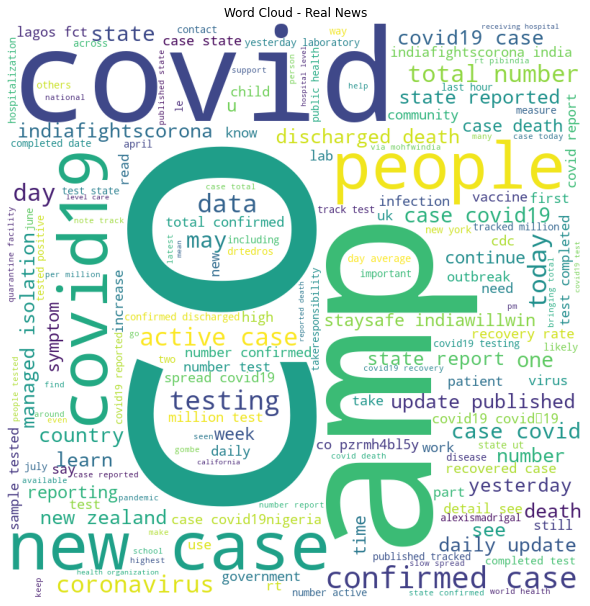

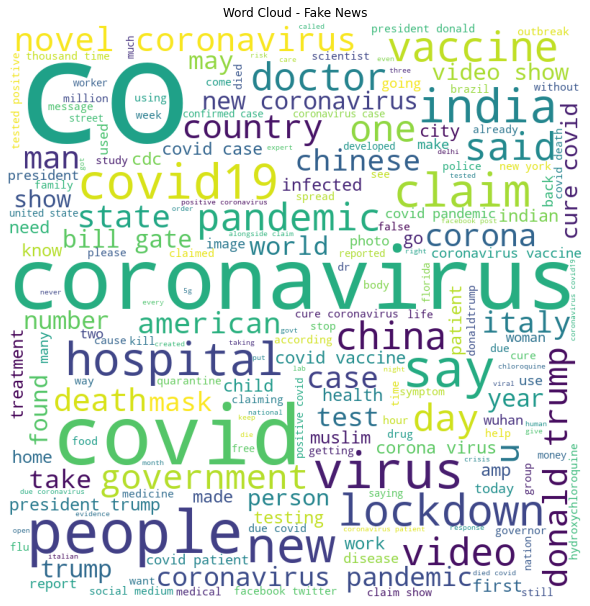

In [7]:
real_dataset = dataset[dataset.label == "real"]
fake_dataset = dataset[dataset.label == "fake"]

# Function to plot world cloud
def plot_wordCloud(dataset, title):
    
    # Join all strings from dataset
    words_str = ' '.join(dataset['text_clean'])
    
    # plot the WordCloud image  
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white',  min_font_size = 10).generate(words_str)
                      
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    
    plt.show()
    
plot_wordCloud(real_dataset, "Word Cloud - Real News")
plot_wordCloud(fake_dataset, "Word Cloud - Fake News")

### Top-Ten verwendeten Wörter <a class="anchor" id="chapter3-3"></a>

In [8]:
def get_topTenWords(dataset, title):
    
    # Join all strings from dataset
    words_str = ' '.join(dataset['text_clean'])
    
    # Split string into word-list
    countWords= Counter(words_str.split()) 
    
    # Count ten most used words
    topTenWords = countWords.most_common(10)
    
    # Transform tupel
    transformed_topTenWords = list(zip(*topTenWords))
    
    # Plot graph
    fig = px.bar(x=transformed_topTenWords[0], y=transformed_topTenWords[1], title=title, color_discrete_sequence =['orange']*10, labels=dict(x="Word", y="Count"))
    fig.show()

get_topTenWords(real_dataset, "Top 10 Used Words - Real News")
get_topTenWords(fake_dataset, "Top 10 Used Words - Fake News")

### Artikel Längen <a class="anchor" id="chapter3-4"></a>

In [9]:
def plot_articleLength(dataset, title):
    
    dataset['text_length'].iplot(
        kind='hist',
        bins=100,
        xTitle='Articel Length',
        linecolor='black',
        yTitle='Count',
        title=title)

    avg_len = sum(dataset['text_length']) / len(dataset['text_length'])
    print("Avg. Article Length: " + str(round(avg_len)) + " words")

plot_articleLength(real_dataset, "Article Text Length Distribution - Real News")
plot_articleLength(fake_dataset, "Article Text Length Distribution - Fake News")

Avg. Article Length: 32 words


Avg. Article Length: 22 words


## Modelle <a class="anchor" id="chapter4"></a>

Im folgenden Abschnitte werden die Machine Learning Modelle
* Naive Bayes
* Gradient Boosting
* Support Vector Machine

vorgestellt. Der Naive Bayes Klassifizierer wird dabei als Benchmark-Modell verwendet, es dient somit als Ausgangspunkt für die Evaluierung der anderen Algorithmen. Dabei werden zudem die Standardparameter verwendet, für Gradient Boosting and Support Vector Machinen werden die Hyperparameter mit Hilfe von Grid-Search optimiert. Durch optimierte Hyperparameter kann die Genauigkeit der Modelle deutlich gesteigert werden, auch wenn das Verfahren rechenaufwendig ist, lohnt es sich daher.

Die folgende Funktion dient zur Evaluierung der Modelle:

In [10]:
def eval_model(model, model_name):
    
    # predict the labels on validation dataset
    prediction = model.predict(test_text_tfidf)
    
    # draw confusion matrix
    confusionMatrix = plot_confusion_matrix(
        model, 
        test_text_tfidf, test_label, 
        display_labels= ['real', 'fake'],
        cmap=plt.cm.Blues)
    
    confusionMatrix.ax_.set_title("Confusion matrix - " + model_name)
    plt.show()

    # draw ROC-curve
    rocCurve = plot_roc_curve(model, test_text_tfidf, test_label)
    rocCurve.ax_.set_title("Receiver Operating Characteristic (ROC) Curve + " + model_name)
    plt.show()  

    # Use accuracy_score function to get the accuracy
    print(model_name + " Accuracy Score -> ", str(round(accuracy_score(test_label, prediction)*100, 2)) + "%")

    # Use precision function to get the precision
    print(model_name + " Precision Score -> ", str(round(precision_score(test_label, prediction)*100, 2)) + "%")

    # Use recall function to get the recall
    print(model_name + " Recall Score -> ", str(round(recall_score(test_label, prediction)*100, 2)) + "%")

    # Use f1_score function to get the f1 score
    print(model_name + " F1 Score -> ", str(round(f1_score(test_label, prediction), 2)))

### Naive Bayes Klassifizierer <a class="anchor" id="chapter4-1"></a>

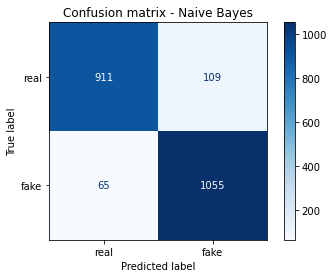

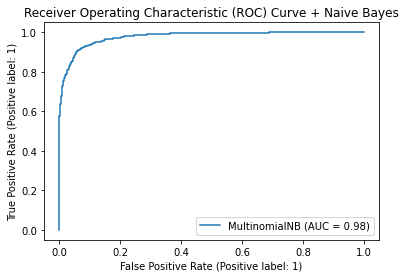

Naive Bayes Accuracy Score ->  91.87%
Naive Bayes Precision Score ->  90.64%
Naive Bayes Recall Score ->  94.2%
Naive Bayes F1 Score ->  0.92


In [11]:
# fit the training dataset on the NB classifier
NB_classifier = naive_bayes.MultinomialNB()
NB_classifier.fit(train_text_tfidf, train_label.values.ravel())

# evalute model
eval_model(NB_classifier, "Naive Bayes")

### Gradient Boosting Klassifizierer <a class="anchor" id="chapter4-2"></a>

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best Parameters


,learning_rate,max_depth,n_estimators
0,0.15,5,1000


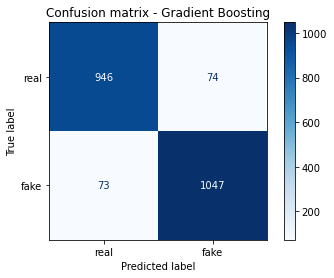

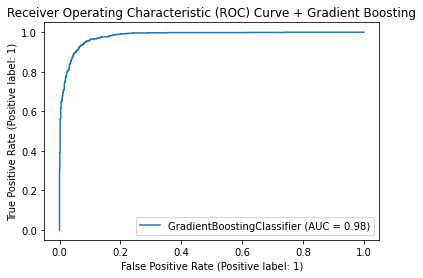

Gradient Boosting Accuracy Score ->  93.13%
Gradient Boosting Precision Score ->  93.4%
Gradient Boosting Recall Score ->  93.48%
Gradient Boosting F1 Score ->  0.93


In [12]:
# Hyperparameters
learning_rate = [0.15,0.1,0.05,0.01]
n_estimators = [100,250,500,750,1000]
max_depth = [2,3,4,5]

grid = {'learning_rate': learning_rate,
        'n_estimators': n_estimators,
        'max_depth': max_depth }

# Classifier - Algorithm - Gradient Boosting
# fit the training dataset on the classifier to find best parameters
GBC_classifier = GradientBoostingClassifier()
GBC_gridSearch = GridSearchCV(GBC_classifier, grid, cv = 3, verbose=2, n_jobs = -1)
GBC_gridSearch.fit(train_text_tfidf, train_label.values.ravel())

# print best paramters
print("Best Parameters")
param_best = pd.DataFrame(GBC_gridSearch.best_params_, index=[0])
display(param_best)

# fit the training model on the classifier with optimized parameters
GBC_classifier = GradientBoostingClassifier(learning_rate=param_best['learning_rate'][0], n_estimators=param_best['n_estimators'][0], max_depth=param_best['max_depth'][0])
GBC_classifier.fit(train_text_tfidf, train_label.values.ravel())

# evalute model
eval_model(GBC_classifier, "Gradient Boosting")

### Support Vector Machinen <a class="anchor" id="chapter4-3"></a>

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters


,C,gamma,kernel
0,10,1,rbf


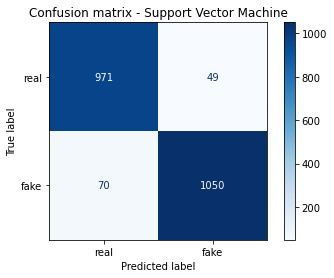

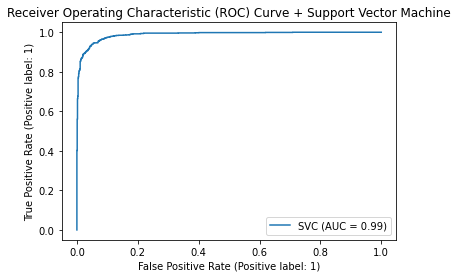

Support Vector Machine Accuracy Score ->  94.44%
Support Vector Machine Precision Score ->  95.54%
Support Vector Machine Recall Score ->  93.75%
Support Vector Machine F1 Score ->  0.95


In [13]:
# Hyperparameters
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['linear', 'rbf']

grid = {'C': C,
        'gamma': gamma,
        'kernel': kernel }

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier to find best parameters
SVM_classifier = svm.SVC(probability=True)
SVM_gridSearch = GridSearchCV(SVM_classifier, grid, cv = 3, verbose=2, n_jobs = -1)
SVM_gridSearch.fit(train_text_tfidf, train_label.values.ravel())

# print best paramters
print("Best Parameters")
param_best = pd.DataFrame(SVM_gridSearch.best_params_, index=[0])
display(param_best)

# fit the training model on the classifier with optimized parameters
SVM_classifier = svm.SVC(probability=True, C=param_best['C'][0], gamma=param_best['gamma'][0], kernel=param_best['kernel'][0])
SVM_classifier.fit(train_text_tfidf, train_label.values.ravel())

# evalute model
eval_model(SVM_classifier, "Support Vector Machine")

### Recurrent  Neural Network

In [14]:
train = tf.data.Dataset.from_tensor_slices((dataset_train.text_clean, dataset_train.label_encoded))
test = tf.data.Dataset.from_tensor_slices((dataset_test.text_clean, dataset_test.label_encoded))

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train.map(lambda text_clean, label: text_clean))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

history = model.fit(train, epochs=10, validation_data=test, validation_steps=30)



Epoch 1/10
101/101 [==============================] - 10s 98ms/step - loss: 0.6714 - accuracy: 0.4991 - val_loss: 0.5922 - val_accuracy: 0.7328
Epoch 2/10
101/101 [==============================] - 5s 48ms/step - loss: 0.4098 - accuracy: 0.8715 - val_loss: 0.3077 - val_accuracy: 0.8844
Epoch 3/10
101/101 [==============================] - 4s 37ms/step - loss: 0.2051 - accuracy: 0.9368 - val_loss: 0.2102 - val_accuracy: 0.9214
Epoch 4/10
101/101 [==============================] - 4s 37ms/step - loss: 0.1267 - accuracy: 0.9634 - val_loss: 0.2173 - val_accuracy: 0.9260
Epoch 5/10
101/101 [==============================] - 3s 27ms/step - loss: 0.0843 - accuracy: 0.9796 - val_loss: 0.2337 - val_accuracy: 0.9323
Epoch 6/10
101/101 [==============================] - 2s 21ms/step - loss: 0.0595 - accuracy: 0.9864 - val_loss: 0.2132 - val_accuracy: 0.9417
Epoch 7/10
101/101 [==============================] - 2s 21ms/step - loss: 0.0433 - accuracy: 0.9927 - val_loss: 0.2580 - val_accuracy: 0.939

34/34 [==============================] - 0s 8ms/step - loss: 0.3143 - accuracy: 0.9411
Test Loss: 0.3142913281917572
Test Accuracy: 0.941121518611908


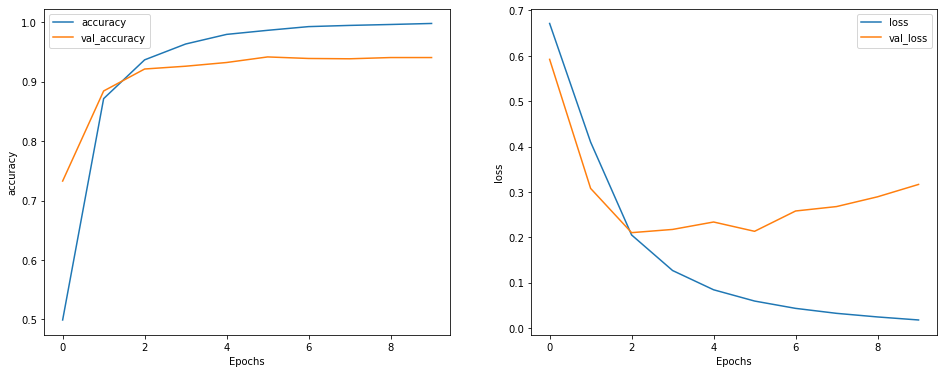

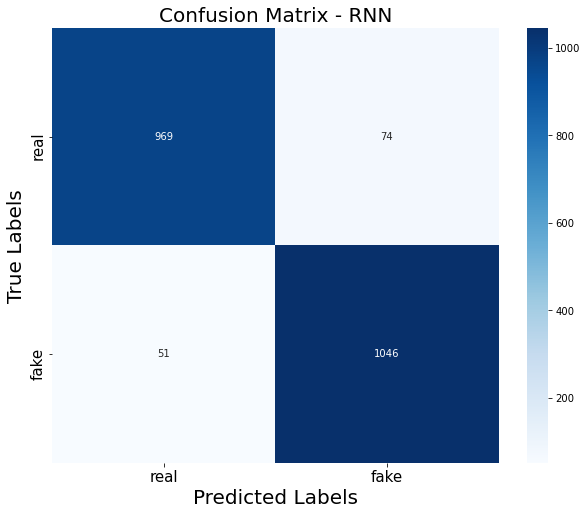

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Test Loss / Accuracy
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Confusion Matrix
predictions = model.predict(test)
pred_labels = (predictions > 0).astype(np.int)

matrix = tf.math.confusion_matrix(pred_labels, test_label)


plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap=plt.cm.Blues, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix - RNN', size=20) 
ax.xaxis.set_ticklabels(['real','fake'], size=15)
ax.yaxis.set_ticklabels(['real','fake'], size=15)

    
plt.show()

## Praktische Anwendung <a class="anchor" id="chapter5"></a>

Damit die trainierten Modelle auch in der Praxis Anwendung finden können, müssen die zu überprüfenden Artikel geladen und vorbereitet werden. Dazu können Nutzer*innen den Link zu einem Text kopieren, dieser wird dann heruntergeladen, der Text extrahiert, bereinigt und mit Hilfe des TF-IDF Algorithmus vektorisiert. Anschließend kann mit den Modellen abgeschätzt werden, ob es sich um Fake News oder echte Nachrichten handelt.  

In [23]:
# Articel-URL (User Input)
#url = 'https://www.nytimes.com/article/what-is-coronavirus.html'
url = 'https://rfangle.com/politics/biden-administration-loses-20-million-vaccine/'

# Simulate User
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

# Check if URL is valid
regex = re.compile(
        r'^(?:http|ftp)s?://'
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|'
        r'localhost|'
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'
        r'(?::\d+)?'
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)

if (re.match(regex, url) == None):
    print('Maleformed URL - Please enter a valid URL!')
    raise StopExecution
    
# Get articel text
html_page = requests.get(url, headers=headers, timeout = 30).text
text = newspaper.fulltext(html_page)

if(len(text) < 500):
    print("Articel is too short to be analyzed - Please chose another articel!")
    raise StopExecution
    
# Preprocessing
# content to lower and split into words 
tokenizer = RegexpTokenizer(r'\w+')
content = tokenizer.tokenize(text.lower())
    
# content without punctuation
punctuation_chars = string.punctuation + '”' + '“' + '—'
translation_func = str.maketrans('', '', punctuation_chars)
content = [w.translate(translation_func) for w in content]
    
# content without stopwords
stop_words = set(stopwords.words('english'))
content = [w for w in content if not w in stop_words]
    
# content without numbers
content = [w for w in content if not w.isdigit()]
    
# content without single letters
content = [w for w in content if not len(w) == 1]
    
# content lemmatized
lemmatizer = WordNetLemmatizer()
content = [lemmatizer.lemmatize(w) for w in content]

content = [str(content)]
content_tfidf = tfidf_vect.transform(content)

# Get model predictions
predictions_NB = NB_classifier.predict(content_tfidf)
predictions_GBC = GBC_classifier.predict(content_tfidf)
predictions_SVM = SVM_classifier.predict(content_tfidf)
# predictions_KNN = model.predict(str(content_tfidf))
# predictions_KNN = (predictions_KNN > 0).astype(np.int)

print("Naive Bayes: " + le.inverse_transform(predictions_NB) + str(NB_classifier.predict_proba(content_tfidf)))
print("Gradient Boosting: " + le.inverse_transform(predictions_GBC) + str(GBC_classifier.predict_proba(content_tfidf)))
print("Support Vector Machine: " + le.inverse_transform(predictions_SVM) + str(SVM_classifier.predict_proba(content_tfidf)))
# print("KNN: " + le.inverse_transform(predictions_KNN))

['Naive Bayes: fake[[0.96966009 0.03033991]]']
['Gradient Boosting: fake[[0.99893227 0.00106773]]']
['Support Vector Machine: fake[[0.99548247 0.00451753]]']
